# Notes
Assumptions:

---

Time Constraints:
Nonprofit is trying to generate interest for gala happening around the beggining of the summer, we assume street teams would be out canvassing in the three preceding months. March - Mid June.

Counter Values: Assume 'entries' and 'exits' columns reflect cumulative counts that could only increase as time moved forward. Thus, we removed any rows with negative values in differential columns and values greater than 100000 (Approximately X% of the rows)

Target Metrics:
Did not differentiate between entries and exits for a station, but rather relied on 'total_traffic' to determine which station would have the most foot traffic at a given time.

Steps:
- Read data from turnstile
- Preprocess Data




In [1]:
#Import required packages
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns

In [2]:
#Reads files in turnstile directory into a files list 
from os import listdir
from os.path import isfile, join
files = [f for f in listdir('./Data/Turnstile_data') if isfile(join('./Data/Turnstile_data', f))]

# Clean and Preprocess Data

In [3]:
# Create initial DataFrame
dfs = pd.DataFrame()
for file in files:
    print("Loading {}".format(str("./Data/Turnstile_data/"+file)))
    df = pd.read_csv('./Data/Turnstile_data/' + file)
    dfs = dfs.append(df)    

dfs.info()  
initial_shape = dfs.shape

Loading ./Data/Turnstile_data/turnstile_160305.txt
Loading ./Data/Turnstile_data/turnstile_160312.txt
Loading ./Data/Turnstile_data/turnstile_160319.txt
Loading ./Data/Turnstile_data/turnstile_160326.txt
Loading ./Data/Turnstile_data/turnstile_160402.txt
Loading ./Data/Turnstile_data/turnstile_160409.txt
Loading ./Data/Turnstile_data/turnstile_160416.txt
Loading ./Data/Turnstile_data/turnstile_160423.txt
Loading ./Data/Turnstile_data/turnstile_160430.txt
Loading ./Data/Turnstile_data/turnstile_160507.txt
Loading ./Data/Turnstile_data/turnstile_160514.txt
Loading ./Data/Turnstile_data/turnstile_160521.txt
Loading ./Data/Turnstile_data/turnstile_160528.txt
Loading ./Data/Turnstile_data/turnstile_160604.txt
Loading ./Data/Turnstile_data/turnstile_160611.txt
Loading ./Data/Turnstile_data/turnstile_160618.txt
Loading ./Data/Turnstile_data/turnstile_170304.txt
Loading ./Data/Turnstile_data/turnstile_170311.txt
Loading ./Data/Turnstile_data/turnstile_170318.txt
Loading ./Data/Turnstile_data/t

In [4]:
#Function to preprocess data
def preprocess(df):
    #Standardize column names
    df.columns = df.columns.str.strip()
    
    #Change Time Column to datetime format and round to nearest hour
    df['TIME'] = pd.to_datetime(df.TIME, format="%H:%M:%S").dt.round('H')
    df['TIME'] = pd.to_datetime(df.TIME, format="%H:%M:%S").dt.time
    
    #Standardize dates, replace dates not in format MM/DD/YEAR to NaN and remove those rows
    df['DATE'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y', errors='coerce')
    df.dropna(inplace=True)
    
    #Create day of week 'DOW' column from data column
    dfs['DOW'] = df['DATE'].dt.weekday_name
       
    #Drop Unncessary columns
    df = df.drop(['C/A','UNIT','LINENAME', 'DIVISION', 'DATE'], axis=1)   
    
    prior_shape = df.shape
    
    # Remove non 'REGULAR' audits from Desc column 
    df.drop(df.DESC != 'REGULAR', inplace = True)
    
    post_shape = df.shape
    desc_rows_removed_perc = (prior_shape[0]-post_shape[0]) / prior_shape[0]  * 100

    print("Percentage of Non Regular Data Removed  = {:08.6f} %".format(desc_rows_removed_perc))
    
    return df

In [5]:
df = preprocess(dfs)

Percentage of Non Regular Data Removed  = 0.001038 %


In [6]:
#Entry and exit data are cumulative, need to adjust to periodic interval counts.
df['DIFFS_ENTRIES'] = df['ENTRIES'].diff()
df['DIFFS_EXIT'] = df['EXITS'].diff()

In [7]:
#Remove turnstile Data in DIFFS_ENTRIES and DIFFS_EXITS that is less than zero and greater than 1e5 (Borderline)
negative_diff_entries = df['DIFFS_ENTRIES'] < 0
df.loc[negative_diff_entries,'DIFFS_ENTRIES'] = np.nan

large_diff_entries =  df['DIFFS_ENTRIES'] > 1e5
df.loc[large_diff_entries,'DIFFS_ENTRIES'] = np.nan

negative_diff_exits = df['DIFFS_EXIT'] < 0
df.loc[negative_diff_exits,'DIFFS_EXIT'] = np.nan

large_diff_exits =  df['DIFFS_EXIT'] > 1e5
df.loc[large_diff_exits,'DIFFS_EXIT'] = np.nan

In [8]:
#Add Column with Total Number of Individuals Entering and Exiting the Station
df['TOTAL_TRAFFIC'] = df['DIFFS_ENTRIES'] + df['DIFFS_EXIT']

In [9]:
#Remove Unused Data Columns
df.drop(['SCP','DESC','ENTRIES', 'EXITS', 'DIFFS_ENTRIES','DIFFS_EXIT'], axis=1, inplace=True)

In [10]:
#Percent of data equal to NaN
nulls = df['TOTAL_TRAFFIC'].isnull()
percent_null = len(df.loc[nulls,'TOTAL_TRAFFIC']) / len(df)
f'{percent_null:.2%} of the data is not useable'

'3.38% of the data is not useable'

In [11]:
#Remove Rows with NaN Values that are unusable
df.dropna(inplace=True)

In [12]:
#Assumption
#1-Remove Time Between Midnight and 7 am
even_am = datetime.time(11,0,0)
midnight = datetime.time(0,0,0)
df = df.loc[(df.TIME >= even_am) | (df.TIME == midnight)]

# Generate Data For Graphs

In [13]:
df_station_by_traffic_sum = df.groupby(['STATION'])[['TOTAL_TRAFFIC']].sum()

In [14]:
top_10_list_Total_Traffic = df_station_by_traffic_sum.sort_values(by=['TOTAL_TRAFFIC'], ascending = False)[0:10]

In [15]:
df_station_by_traffic_3_month_yearly_average = df.groupby(['STATION'])[['TOTAL_TRAFFIC']].sum()/3

In [16]:
top_10_list_3_month_yearly_Traffic =df_station_by_traffic_3_month_yearly_average.sort_values(by=['TOTAL_TRAFFIC'], ascending = False)[0:10]

In [17]:
#Y-AXIS Ticks of Top Stations
top10_sum = [i for i in top_10_list_Total_Traffic.index]
top10_avg = [i for i in top_10_list_3_month_yearly_Traffic.index]
top5_sum = [i for i in top_10_list_Total_Traffic.index[0:5]]

In [20]:
#Group data by station and day of week to find average daily visitors per station. 
#Reset index of new dataframe to be used to extract top ten stations.
average_daily_station_entries = df.groupby(['STATION','DOW'])[['TOTAL_TRAFFIC']].sum()/54
average_daily_station_entries=average_daily_station_entries.reset_index()

In [21]:
#Generate Data frame with top 10 stations
average_daily_total_per_top_10_stations= average_daily_station_entries[average_daily_station_entries['STATION'].isin(top10_sum)].copy()

In [22]:
#Replace Days of Week by integer values to seperate into weekday and weekend
average_daily_total_per_top_10_stations.replace('Monday', 0, inplace=True)
average_daily_total_per_top_10_stations.replace('Tuesday', 1, inplace=True)
average_daily_total_per_top_10_stations.replace('Wednesday', 2, inplace=True)
average_daily_total_per_top_10_stations.replace('Thursday', 3, inplace=True)
average_daily_total_per_top_10_stations.replace('Friday', 4, inplace=True)
average_daily_total_per_top_10_stations.replace('Saturday', 5, inplace=True)
average_daily_total_per_top_10_stations.replace('Sunday', 6, inplace=True)

# Seperate Data per Weekday and Weekend Top 10

In [23]:
#Seperate average daily top 10 by weekday
average_weekday_total_top_10_stations = average_daily_total_per_top_10_stations[average_daily_total_per_top_10_stations.DOW < 5]

In [24]:
#Seperate average daily top 10 by weekend
average_weekend_total_top_10_stations = average_daily_total_per_top_10_stations[average_daily_total_per_top_10_stations.DOW > 4]

# Seperate Data per Weekday and Weekend Top 5

In [43]:
#Generate Data frame with top 5 stations
average_daily_total_per_top_5_stations= average_daily_station_entries[average_daily_station_entries['STATION'].isin(top5_sum)].copy()

In [44]:
#Replace Days of Week by integer values to seperate into weekday and weekend
average_daily_total_per_top_5_stations.replace('Monday', 0, inplace=True)
average_daily_total_per_top_5_stations.replace('Tuesday', 1, inplace=True)
average_daily_total_per_top_5_stations.replace('Wednesday', 2, inplace=True)
average_daily_total_per_top_5_stations.replace('Thursday', 3, inplace=True)
average_daily_total_per_top_5_stations.replace('Friday', 4, inplace=True)
average_daily_total_per_top_5_stations.replace('Saturday', 5, inplace=True)
average_daily_total_per_top_5_stations.replace('Sunday', 6, inplace=True)

In [47]:
#Seperate average daily top 5 by weekday
average_weekday_total_top_5_stations = average_daily_total_per_top_5_stations[average_daily_total_per_top_5_stations.DOW < 5]

In [45]:
#Seperate average daily top 5 by weekend
average_weekend_total_top_5_stations = average_daily_total_per_top_5_stations[average_daily_total_per_top_5_stations.DOW > 4]

# TODO:
- Create a function to seperate top 5 and top 10

# Generate Graphs
- Plot 1 - Total sum of traffic accross March, April, May, June for  2016-2018
- Plot 2 - Average 4 Month per year across March, April, May, June for  2016-2018
- Plot 3 - Top 10 Stations per weekday
- Plot 4 - Top 5 Stations per weekend

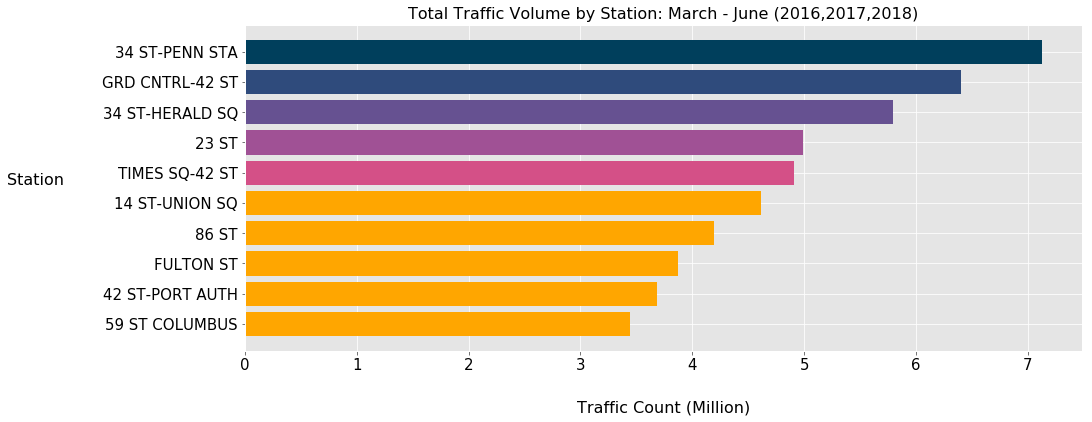

In [245]:
#Identified top 10 stations by volume of turnstile entries and exits
#Source for reference -> https://matplotlib.org/gallery/lines_bars_and_markers/barh.html
colorlist = ['#003f5c','#2f4b7c','#665191','#a05195','#d45087','#ffa600','#ffa600','#ffa600','#ffa600','#ffa600']
tick_list = ['0','1','2','3','4','5','6','7','8']

fig, ax = plt.subplots(1, figsize=(15, 6))
y_pos = np.arange(10)

ax.set_xticklabels(tick_list,fontsize = 18, color='black')
ax.xaxis.set_label_coords(.5,-.15)
ax.set_xlabel('Traffic Count (Million)',fontsize=16, color="black")

ax.set_yticks(y_pos)
ax.set_yticklabels(top10_sum, fontsize = 14,color='black')
ax.set_ylabel('Station',fontsize = 16,rotation = 0, color="black")
ax.yaxis.set_label_coords(-.25,.5)


ax.barh(y_pos, top_10_list_Total_Traffic['TOTAL_TRAFFIC'], color=colorlist, align='center')
ax.invert_yaxis();
ax.tick_params(labelsize=15)
plt.title('Total Traffic Volume by Station: March - June (2016,2017,2018)', fontsize=16);
plt.savefig('TotalTrafficAllTime.svg')
plt.savefig('TotalTrafficAllTime.jpg')


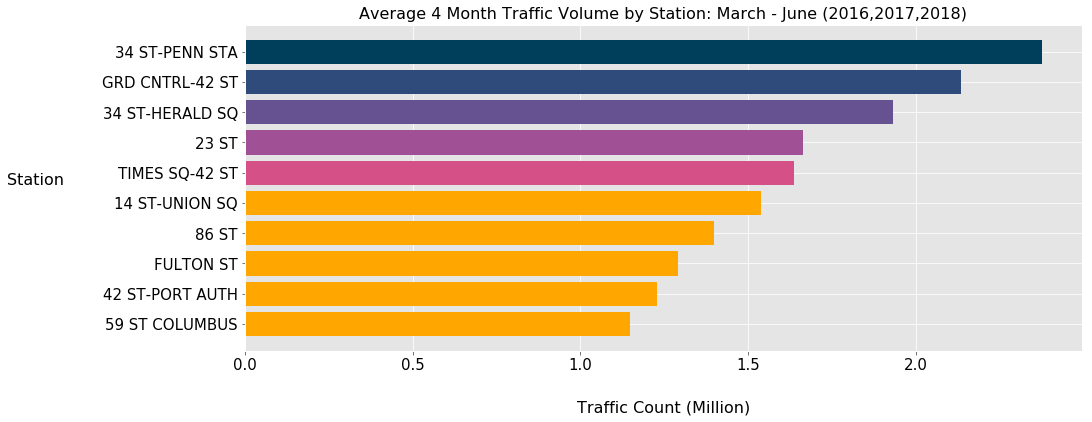

In [246]:
#Identified top 10 stations by volume of turnstile entries and exits
#Source for reference -> https://matplotlib.org/gallery/lines_bars_and_markers/barh.html
colorlist = ['#003f5c','#2f4b7c','#665191','#a05195','#d45087','#ffa600','#ffa600','#ffa600','#ffa600','#ffa600']
tick_list = ['0.0','0.5','1.0', '1.5', '2.0']

fig, ax = plt.subplots(1, figsize=(15, 6))
y_pos = np.arange(10)

ax.set_xticklabels(tick_list,fontsize = 18,color='black')
ax.xaxis.set_label_coords(.5,-.15)
ax.set_xlabel('Traffic Count (Million)',fontsize=16, color="black")

ax.set_yticks(y_pos)
ax.set_yticklabels(top10_avg, fontsize = 14,color='black')
ax.set_ylabel('Station',fontsize = 16,rotation = 0, color="black")
ax.yaxis.set_label_coords(-.25,.5)


ax.barh(y_pos, top_10_list_3_month_yearly_Traffic['TOTAL_TRAFFIC'], color=colorlist, align='center')
ax.invert_yaxis();
ax.tick_params(labelsize=15)
plt.title('Average 4 Month Traffic Volume by Station: March - June (2016,2017,2018)', fontsize=16);
plt.savefig('Average4MonthAllTime.svg')
plt.savefig('Average4MonthAllTime.jpg')

In [288]:
colorlist[0]

NameError: name 'color_list' is not defined

In [286]:
top10_sum.index('34 ST-PENN STA')

0

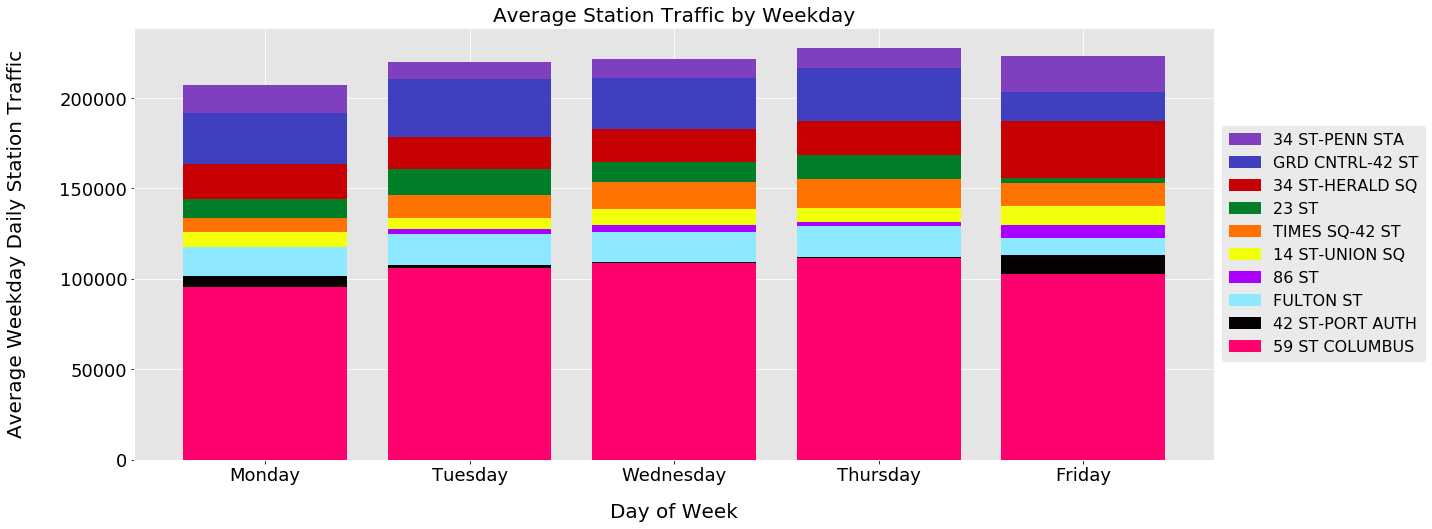

In [296]:
# for each station, plot the traffic by weekday
weekday_list = ['','Monday','Tuesday','Wednesday', 'Thursday', 'Friday']
colorlist_bar = ['#7F3FBF','#3F3FBF','#C60003','#007F28','#FD7201','#F2FF0A','#aa00ff','#8EE8FF','#050002','#ff006e']
fig = plt.figure(figsize = (15, 6))

x = average_weekday_total_top_10_stations.DOW.unique()
axes = fig.add_axes([0, 0, 1, 1])

for station in top10_sum:
    y = average_weekday_total_top_10_stations[average_weekday_total_top_10_stations['STATION'] == station]['TOTAL_TRAFFIC']
    axes.bar(x, y, label = station, color = colorlist_bar[top10_sum.index(station)] )
    

axes.set_xlabel('Day of Week', fontsize = 20,color='black')
axes.set_ylabel('Average Weekday Daily Station Traffic', fontsize = 20,color='black')
axes.set_title('Average Station Traffic by Weekday', fontsize = 20, color='black')
axes.set_xticklabels(weekday_list,rotation=0, fontsize = 18, color='black')

axes.yaxis.set_label_coords(-.1,.5)
axes.xaxis.set_label_coords(.5,-0.1)
axes.legend(fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5));
axes.tick_params(colors = 'black',labelsize=18)
plt.savefig('AverageTrafficWeekday.svg')
plt.savefig('AverageTrafficWeekday.jpg')

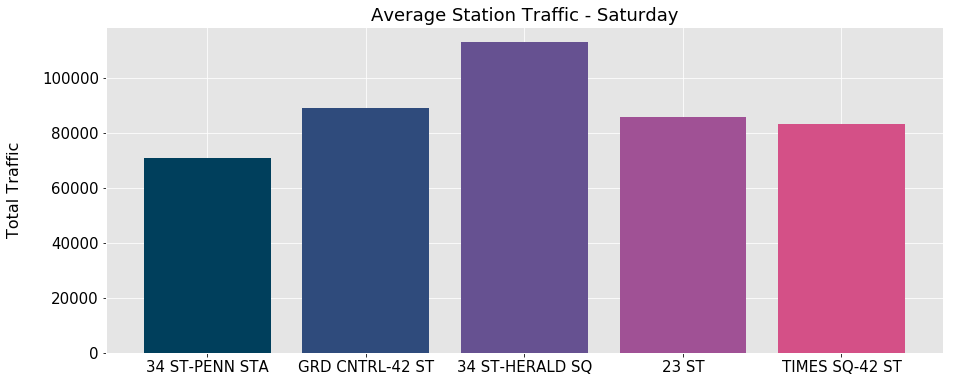

In [297]:
#Identified top 10 stations by volume of turnstile entries and exits
#Source for reference -> https://matplotlib.org/gallery/lines_bars_and_markers/barh.html
#TODO: Remove Scientific Notation, Increase X-Axis Tick Mark
colorlist = ['#003f5c','#2f4b7c','#665191','#a05195','#d45087']

fig, ax = plt.subplots(1, figsize=(15, 6))
x_pos = np.arange(5)

ax.set_ylabel('Total Traffic', fontsize = 16, color="black")
ax.yaxis.set_label_coords(-.1,.5)
ax.set_xticks(x_pos)
ax.set_xticklabels(top5_sum, fontsize = 16, color="black")

plt.bar(x_pos,average_weekend_total_top_5_stations[average_weekend_total_top_5_stations['DOW']==5]['TOTAL_TRAFFIC'], color=colorlist, align='center')
ax.tick_params(labelsize=15)
plt.title('Average Station Traffic - Saturday', fontsize=18);
ax.tick_params(colors = 'black')
plt.savefig('AverageTrafficSaturday.svg')
plt.savefig('AverageTrafficSaturday.jpg')

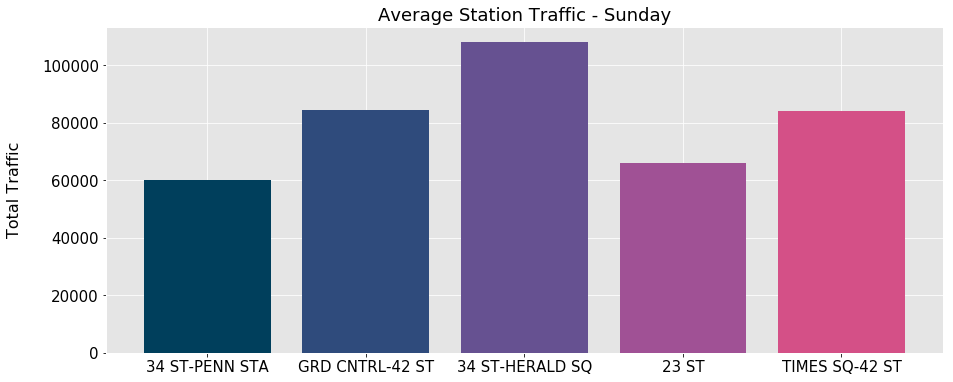

In [298]:
#Identified top 10 stations by volume of turnstile entries and exits
#Source for reference -> https://matplotlib.org/gallery/lines_bars_and_markers/barh.html
#TODO: Remove Scientific Notation, Increase X-Axis Tick Mark
colorlist = ['#003f5c','#2f4b7c','#665191','#a05195','#d45087']

fig, ax = plt.subplots(1, figsize=(15, 6))
x_pos = np.arange(5)

ax.set_ylabel('Total Traffic', fontsize = 16, color="black")
ax.yaxis.set_label_coords(-.1,.5)
ax.set_xticks(x_pos)
ax.set_xticklabels(top5_sum, fontsize = 16, color="black")


plt.bar(x_pos,average_weekend_total_top_5_stations[average_weekend_total_top_5_stations['DOW']==6]['TOTAL_TRAFFIC'], color=colorlist, align='center')
ax.tick_params(labelsize=15)
plt.title('Average Station Traffic - Sunday', fontsize=18);
ax.tick_params(colors = 'black')
plt.savefig('AverageTrafficSunday.svg')
plt.savefig('AverageTrafficSunday.jpg')

# TODO: 
- ADD HEATMAP
- Distribution of Total Entry by Station to show most station have small traffic volume while only a small number have large traffic volume
- Bar Plot - Traffic Flow by Weekday


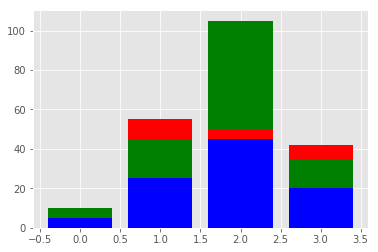

In [280]:
import matplotlib.pyplot as plt

A = [5., 30., 45., 22.]
B = [5., 25., 50., 20.]
C = [5., 20., 55., 15.]


X = range(4)

plt.bar(X, A, color = 'b')
plt.bar(X, B, color = 'r', bottom = A)
plt.bar(X, C, color = 'g', bottom = B)
plt.show()